# Video2X Codespace Notebook (Updated)

Updated for the modern Video2X v6+ Docker implementation in GitHub Codespace.

**Features:**
- 🐳 Modern Video2X v6+ via Docker
- 🎯 Real-ESRGAN, Anime4K, and RIFE processors
- 📁 Local file system storage
- ⚡ Fast C/C++ implementation
- 🔧 Interactive configuration

**Note:** This uses the modern Docker-based Video2X which is much faster and more reliable than the old Python version.

In [10]:
# Step 0: System Check and Setup
import subprocess
import sys
import os
from pathlib import Path

print("🔍 Checking system resources...")

# Check Docker
try:
    result = subprocess.run(['docker', '--version'], capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✅ Docker available: {result.stdout.strip()}")
        
        # Check if Docker daemon is running
        daemon_check = subprocess.run(['docker', 'info'], capture_output=True, text=True)
        if daemon_check.returncode != 0:
            print("⚠️ Docker daemon not running - attempting to start...")
            # Try to start Docker daemon
            start_result = subprocess.run(['sudo', 'service', 'docker', 'start'], 
                                        capture_output=True, text=True)
            if start_result.returncode == 0:
                print("✅ Docker daemon started")
            else:
                print("❌ Failed to start Docker daemon")
                print("💡 Run: ./scripts/start-docker.sh in terminal")
    else:
        print("❌ Docker not available")
except FileNotFoundError:
    print("❌ Docker not installed")

# Check Video2X Docker image
try:
    result = subprocess.run(['docker', 'images', '--format', 'table {{.Repository}}:{{.Tag}}', 'ghcr.io/k4yt3x/video2x'], 
                          capture_output=True, text=True)
    if 'ghcr.io/k4yt3x/video2x' in result.stdout:
        print("✅ Video2X Docker image available")
        # Show available image
        lines = result.stdout.strip().split('\n')
        for line in lines[1:]:  # Skip header
            if line.strip():
                print(f"   📦 {line.strip()}")
    else:
        print("⚠️ Video2X Docker image not found")
        print("🔄 Pulling Video2X image...")
        pull_result = subprocess.run(['docker', 'pull', 'ghcr.io/k4yt3x/video2x:latest'], 
                                   capture_output=True, text=True)
        if pull_result.returncode == 0:
            print("✅ Video2X image pulled successfully")
        else:
            print(f"❌ Failed to pull image: {pull_result.stderr}")
except Exception as e:
    print(f"❌ Error checking Docker images: {e}")

# Load our Video2X wrapper
workspace_path = Path.home() / 'work' / 'video2x-codespace'
scripts_path = workspace_path / 'scripts'
sys.path.append(str(scripts_path))

try:
    import video2x_wrapper
    print("\n✅ Video2X Python wrapper loaded")
    v2x = video2x_wrapper.Video2X()
    print(f"📁 Workspace: {v2x.workspace_dir}")
except ImportError as e:
    print(f"\n❌ Could not load Video2X wrapper: {e}")
    v2x = None

🔍 Checking system resources...
✅ Docker available: Docker version 28.3.2-1, build 578ccf607d24abc5270e9a4cbd5ba9b5355b042f
⚠️ Video2X Docker image not found
🔄 Pulling Video2X image...
✅ Video2X image pulled successfully

✅ Video2X Python wrapper loaded
📁 Workspace: /workspaces/video2x-codespace


In [11]:
# Step 1: File Management
import pathlib
from IPython.display import display, clear_output
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set up local paths for SciPy notebook environment
workspace_path = Path.home() / 'work' / 'video2x-codespace'
input_dir = workspace_path / 'input'
output_dir = workspace_path / 'output'
temp_dir = workspace_path / 'temp'

# Ensure directories exist
for dir_path in [input_dir, output_dir, temp_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Check for existing files
video_extensions = ['.mp4', '.avi', '.mkv', '.mov', '.wmv', '.flv']
input_files = [f for f in input_dir.iterdir() 
               if f.is_file() and f.suffix.lower() in video_extensions]

if input_files:
    print(f"📹 Found {len(input_files)} video file(s):")
    for i, file in enumerate(input_files, 1):
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"  {i}. {file.name} ({size_mb:.1f} MB)")
    
    # Use the first file as default
    input_file = input_files[0]
    print(f"\n🎯 Selected: {input_file.name}")
else:
    print("📁 No video files found in input directory")
    print(f"📍 Upload files to: {input_dir}")
    print("💡 Use VS Code file explorer to drag and drop videos")
    
    # Create a sample video for testing
    print("\n🎥 Creating sample test video...")
    try:
        subprocess.run([
            'ffmpeg', '-f', 'lavfi', '-i', 'testsrc=duration=5:size=320x240:rate=30',
            str(input_dir / 'sample_test.mp4'),
            '-y', '-loglevel', 'quiet'
        ], check=True)
        input_file = input_dir / 'sample_test.mp4'
        print(f"✅ Created sample video: {input_file.name}")
    except Exception as e:
        print(f"❌ Could not create sample video: {e}")
        input_file = None

📹 Found 1 video file(s):
  1. test_sample.mp4 (0.1 MB)

🎯 Selected: test_sample.mp4


📊 Analyzing: test_sample.mp4
📐 Resolution: 480x360
🎬 FPS: 30.00
📽️ Frames: 300
⏱️ Duration: 10.00 seconds
📁 File size: 0.1 MB
⏳ Estimated processing time: 2.5 minutes (rough estimate)


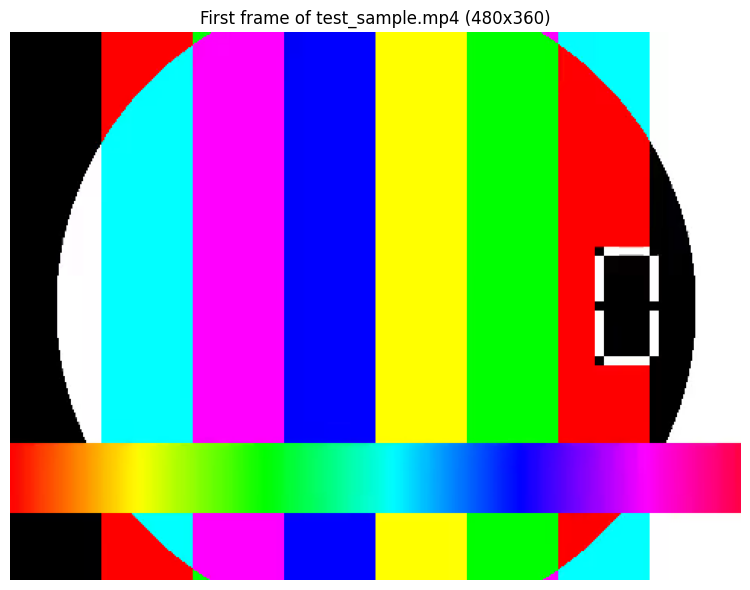

In [12]:
# Step 2: Video Analysis
if input_file and input_file.exists():
    print(f"📊 Analyzing: {input_file.name}")
    
    # Get video properties using OpenCV
    cap = cv2.VideoCapture(str(input_file))
    
    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0
        file_size = input_file.stat().st_size / (1024 * 1024)
        
        print(f"📐 Resolution: {width}x{height}")
        print(f"🎬 FPS: {fps:.2f}")
        print(f"📽️ Frames: {frame_count:,}")
        print(f"⏱️ Duration: {duration:.2f} seconds")
        print(f"📁 File size: {file_size:.1f} MB")
        
        # Estimate processing time
        if frame_count > 0:
            estimated_time = frame_count * 0.5  # Rough estimate: 0.5 seconds per frame
            print(f"⏳ Estimated processing time: {estimated_time/60:.1f} minutes (rough estimate)")
        
        # Read and display first frame
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 6))
            plt.imshow(frame_rgb)
            plt.title(f"First frame of {input_file.name} ({width}x{height})")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        
        cap.release()
    else:
        print("❌ Could not open video file")
else:
    print("⚠️ No video file available for analysis")

In [13]:
# Step 3: Choose Processing Options
print("🎛️ Video2X Processing Options")
print("============================\n")

print("📚 Available Processors:")
print("1. 🎬 Real-ESRGAN - Best for real-world videos, photos")
print("2. 🎌 Anime4K - Optimized for anime/cartoon content")
print("3. 🎞️ RIFE - Frame interpolation for smoother motion")

print("\n⚙️ Scale Factors:")
print("• 2x - Double resolution (480p → 960p)")
print("• 3x - Triple resolution (480p → 1440p)")
print("• 4x - Quadruple resolution (480p → 1920p)")

print("\n💡 Recommendations:")
print("• Real-ESRGAN + 2x: Good balance of quality and speed")
print("• Anime4K + 4x: Best for anime content")
print("• RIFE: For 60fps interpolation (no scaling)")

# Set default options
processor = "realesrgan"  # Default processor
scale = 2                 # Default scale
model = "realesr-animevideov3"  # Default model for Real-ESRGAN

print(f"\n🎯 Default settings: {processor.upper()} with {scale}x scaling")
print("💬 Modify the variables above to change settings")

🎛️ Video2X Processing Options

📚 Available Processors:
1. 🎬 Real-ESRGAN - Best for real-world videos, photos
2. 🎌 Anime4K - Optimized for anime/cartoon content
3. 🎞️ RIFE - Frame interpolation for smoother motion

⚙️ Scale Factors:
• 2x - Double resolution (480p → 960p)
• 3x - Triple resolution (480p → 1440p)
• 4x - Quadruple resolution (480p → 1920p)

💡 Recommendations:
• Real-ESRGAN + 2x: Good balance of quality and speed
• Anime4K + 4x: Best for anime content
• RIFE: For 60fps interpolation (no scaling)

🎯 Default settings: REALESRGAN with 2x scaling
💬 Modify the variables above to change settings


In [ ]:
# Step 4: Process Video
if input_file and input_file.exists() and v2x:
    # Generate output filename
    output_filename = f"{input_file.stem}_{processor}_{scale}x{input_file.suffix}"
    output_file = output_dir / output_filename
    
    print(f"🎬 Starting Video2X Processing")
    print(f"==============================")
    print(f"📥 Input:     {input_file.name}")
    print(f"📤 Output:    {output_filename}")
    print(f"⚙️ Processor: {processor.upper()}")
    print(f"📐 Scale:     {scale}x")
    if processor == "realesrgan":
        print(f"🧠 Model:     {model}")
    print(f"💾 Location:  {output_file}")
    
    print("\n⚠️ Processing will begin when you run this cell.")
    print("⏱️ This may take several minutes depending on video length.")
    print("🔄 You can monitor progress in the terminal output below.")
    
    # Ask for confirmation
    confirm = input("\n▶️ Press Enter to start processing (or 'n' to cancel): ")
    
    if confirm.lower() not in ['n', 'no', 'cancel']:
        print("\n🚀 Starting processing...")
        
        try:
            # Use our Video2X wrapper
            result = v2x.upscale(
                str(input_file),
                str(output_file),
                processor=processor,
                scale=scale
            )
            
            if result:
                print(f"\n✅ Processing completed successfully!")
                print(f"📁 Output saved to: {result}")
                
                # Show file size comparison
                input_size = input_file.stat().st_size / (1024 * 1024)
                output_size = Path(result).stat().st_size / (1024 * 1024)
                print(f"📊 Input size:  {input_size:.1f} MB")
                print(f"📊 Output size: {output_size:.1f} MB")
                print(f"📈 Size ratio:  {output_size/input_size:.1f}x")
            else:
                print("❌ Processing failed. Check the error messages above.")
                
        except Exception as e:
            print(f"❌ Error during processing: {e}")
    else:
        print("⏹️ Processing cancelled.")
        
else:
    if not input_file:
        print("❌ No input file available")
    elif not v2x:
        print("❌ Video2X wrapper not available")
    else:
        print("❌ Input file does not exist")

🎬 Starting Video2X Processing
📥 Input:     test_sample.mp4
📤 Output:    test_sample_realesrgan_2x.mp4
⚙️ Processor: REALESRGAN
📐 Scale:     2x
🧠 Model:     realesr-animevideov3
💾 Location:  /workspaces/video2x-codespace/output/test_sample_realesrgan_2x.mp4

⚠️ Processing will begin when you run this cell.
⏱️ This may take several minutes depending on video length.
🔄 You can monitor progress in the terminal output below.


In [ ]:
# Step 5: View Results
print("📤 Processing Results")
print("===================\n")

# List all output files
output_files = [f for f in output_dir.iterdir() 
                if f.is_file() and f.suffix.lower() in video_extensions]

if output_files:
    print(f"📹 Found {len(output_files)} processed video(s):")
    for i, file in enumerate(output_files, 1):
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"  {i}. {file.name} ({size_mb:.1f} MB)")
        
    # Show comparison with original if available
    if input_file and input_file.exists():
        latest_output = max(output_files, key=lambda f: f.stat().st_mtime)
        
        print(f"\n🔍 Comparing: {input_file.name} vs {latest_output.name}")
        
        # Load both videos for comparison
        cap_input = cv2.VideoCapture(str(input_file))
        cap_output = cv2.VideoCapture(str(latest_output))
        
        if cap_input.isOpened() and cap_output.isOpened():
            # Read first frames
            ret1, frame1 = cap_input.read()
            ret2, frame2 = cap_output.read()
            
            if ret1 and ret2:
                frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
                frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
                
                # Display comparison
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                
                ax1.imshow(frame1_rgb)
                ax1.set_title(f"Original\n{input_file.name}\n{frame1_rgb.shape[1]}x{frame1_rgb.shape[0]}")
                ax1.axis('off')
                
                ax2.imshow(frame2_rgb)
                ax2.set_title(f"Processed\n{latest_output.name}\n{frame2_rgb.shape[1]}x{frame2_rgb.shape[0]}")
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Show resolution comparison
                input_res = f"{frame1_rgb.shape[1]}x{frame1_rgb.shape[0]}"
                output_res = f"{frame2_rgb.shape[1]}x{frame2_rgb.shape[0]}"
                scale_achieved = frame2_rgb.shape[1] / frame1_rgb.shape[1]
                
                print(f"📐 Resolution comparison:")
                print(f"   Original: {input_res}")
                print(f"   Processed: {output_res}")
                print(f"   Scale achieved: {scale_achieved:.1f}x")
            
        cap_input.release()
        cap_output.release()
        
else:
    print("📁 No processed videos found in output directory")
    print("💡 Run the processing step above to generate output videos")

print(f"\n📁 Output directory: {output_dir}")
print("💾 You can download processed videos from the VS Code file explorer")

In [ ]:
# Step 6: Batch Processing (Optional)
print("🔄 Batch Processing")
print("==================\n")

# Find all unprocessed videos
all_input_files = [f for f in input_dir.iterdir() 
                   if f.is_file() and f.suffix.lower() in video_extensions]

# Check which ones haven't been processed yet
processed_names = {f.name for f in output_files} if output_files else set()
unprocessed_files = [f for f in all_input_files 
                     if not any(f.stem in name for name in processed_names)]

if unprocessed_files:
    print(f"📹 Found {len(unprocessed_files)} unprocessed video(s):")
    for i, file in enumerate(unprocessed_files, 1):
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"  {i}. {file.name} ({size_mb:.1f} MB)")
    
    print(f"\n⚙️ Batch settings: {processor.upper()} with {scale}x scaling")
    
    # Estimate total time
    total_frames = 0
    for file in unprocessed_files:
        try:
            cap = cv2.VideoCapture(str(file))
            if cap.isOpened():
                frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                total_frames += frames
            cap.release()
        except:
            pass
    
    if total_frames > 0:
        estimated_time = total_frames * 0.5 / 60  # Rough estimate in minutes
        print(f"⏳ Estimated total time: {estimated_time:.1f} minutes")
    
    # Ask for confirmation
    confirm = input("\n🔄 Process all unprocessed videos? (y/N): ")
    
    if confirm.lower() in ['y', 'yes']:
        print("\n🚀 Starting batch processing...")
        
        for i, file in enumerate(unprocessed_files, 1):
            print(f"\n📹 Processing {i}/{len(unprocessed_files)}: {file.name}")
            
            output_filename = f"{file.stem}_{processor}_{scale}x{file.suffix}"
            output_file = output_dir / output_filename
            
            try:
                result = v2x.upscale(
                    str(file),
                    str(output_file),
                    processor=processor,
                    scale=scale
                )
                
                if result:
                    print(f"   ✅ Completed: {output_filename}")
                else:
                    print(f"   ❌ Failed: {file.name}")
                    
            except Exception as e:
                print(f"   ❌ Error processing {file.name}: {e}")
        
        print("\n🎉 Batch processing completed!")
    else:
        print("⏹️ Batch processing cancelled.")
        
else:
    print("✅ All videos have been processed!")
    print("💡 Add more videos to the input directory for batch processing")